This notebook is a first approach to a classification problem using the famous MNIST dataset. We will use both ML algorithms and Deep NN. 

As MNIST dataset is the 'hello world' task in classification problems, it's a good start point for discovering ML models and Neural Networks.

The main goal of this notebook is not achieve the highest accuracy/score, but make contact with the most popular tools in ML and DL, their hyperparameters, routines to optimize and tuning and so on.

Import necessary packages

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf 
from tensorflow import keras
from sklearn import tree
from sklearn.metrics import mean_squared_error, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC, SVC
import xgboost
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold

# 1. Reading the data
We start by reading and saving the train and test datasets:

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

During all the notebook, we will use only the train dataset, as the test set is used only when submitting your solution to the problem.

The shapes of the sets are:

In [3]:
train.shape, test.shape

((42000, 785), (28000, 784))

# 2. Exploring the data

First data inspections:

In [4]:
train.head(), test.head()

(   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
 0      1       0       0       0       0       0       0       0       0   
 1      0       0       0       0       0       0       0       0       0   
 2      1       0       0       0       0       0       0       0       0   
 3      4       0       0       0       0       0       0       0       0   
 4      0       0       0       0       0       0       0       0       0   
 
    pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
 0       0  ...         0         0         0         0         0         0   
 1       0  ...         0         0         0         0         0         0   
 2       0  ...         0         0         0         0         0         0   
 3       0  ...         0         0         0         0         0         0   
 4       0  ...         0         0         0         0         0         0   
 
    pixel780  pixel781  pixel782  pixel783  
 0         0   

Each column represents the pixel intensity (from 0 to 255), so each instance (digit) is represented by 28 x 28 pixels, and hence 784 feature columns.

We can compute some statistics from the train and test datasets:

In [5]:
train.info(), train.describe(), test.info(), test.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


(None,
               label   pixel0   pixel1   pixel2   pixel3   pixel4   pixel5  \
 count  42000.000000  42000.0  42000.0  42000.0  42000.0  42000.0  42000.0   
 mean       4.456643      0.0      0.0      0.0      0.0      0.0      0.0   
 std        2.887730      0.0      0.0      0.0      0.0      0.0      0.0   
 min        0.000000      0.0      0.0      0.0      0.0      0.0      0.0   
 25%        2.000000      0.0      0.0      0.0      0.0      0.0      0.0   
 50%        4.000000      0.0      0.0      0.0      0.0      0.0      0.0   
 75%        7.000000      0.0      0.0      0.0      0.0      0.0      0.0   
 max        9.000000      0.0      0.0      0.0      0.0      0.0      0.0   
 
         pixel6   pixel7   pixel8  ...      pixel774      pixel775  \
 count  42000.0  42000.0  42000.0  ...  42000.000000  42000.000000   
 mean       0.0      0.0      0.0  ...      0.219286      0.117095   
 std        0.0      0.0      0.0  ...      6.312890      4.633819   
 min     

Now, let's see if there are null values:

In [6]:
train.isnull().sum(), test.isnull().sum()

(label       0
 pixel0      0
 pixel1      0
 pixel2      0
 pixel3      0
            ..
 pixel779    0
 pixel780    0
 pixel781    0
 pixel782    0
 pixel783    0
 Length: 785, dtype: int64,
 pixel0      0
 pixel1      0
 pixel2      0
 pixel3      0
 pixel4      0
            ..
 pixel779    0
 pixel780    0
 pixel781    0
 pixel782    0
 pixel783    0
 Length: 784, dtype: int64)

There's not missing data (NaN), so no treatment is necessary.

# 3. Preparing the data

Due the large amount of data available, we select the first 5000 instances to speed up the process. We also select the last 5000 instances of the train set as validation data for the Neural Network:

In [7]:
train_reduced = train[:5000]
train_val = train[37000:]

Let's identify the data features (X), and the target values (y):

In [8]:
X = train_reduced.drop('label', axis=1)
y = train_reduced['label']

Using train_test_split, we create the train and test sets in a 0.75/0.25 ratio size.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

After the split, and to avoid problems when computing the classification, we compute each class proportion to be sure that all clases are represented with the same weight:

In [10]:
train['label'].value_counts()/len(train), train_reduced['label'].value_counts()/len(train_reduced), y_train.value_counts()/len(y_train), y_test.value_counts()/len(y_test)

(1    0.111524
 7    0.104786
 3    0.103595
 9    0.099714
 2    0.099452
 6    0.098500
 0    0.098381
 4    0.096952
 8    0.096738
 5    0.090357
 Name: label, dtype: float64,
 1    0.1116
 2    0.1090
 6    0.1032
 7    0.1012
 0    0.0988
 3    0.0960
 9    0.0956
 8    0.0954
 4    0.0954
 5    0.0938
 Name: label, dtype: float64,
 2    0.110933
 1    0.106933
 6    0.105867
 7    0.101600
 0    0.100267
 8    0.095467
 9    0.095200
 5    0.095200
 4    0.095200
 3    0.093333
 Name: label, dtype: float64,
 1    0.1256
 3    0.1040
 2    0.1032
 7    0.1000
 9    0.0968
 4    0.0960
 8    0.0952
 6    0.0952
 0    0.0944
 5    0.0896
 Name: label, dtype: float64)

# 4. Defining, training and evaluating the standard models 

We will start with a list of basic ML classification models, training and evaluating the models with the train and test data, respectively.

In [11]:
random_state=42
models = [tree.DecisionTreeClassifier(random_state=random_state), RandomForestClassifier(random_state=random_state), SGDClassifier(random_state=random_state), 
          LinearSVC(random_state=random_state, max_iter=10000), SVC(random_state=random_state, max_iter=10000),
            xgboost.XGBClassifier(random_state=random_state), AdaBoostClassifier(tree.DecisionTreeClassifier(random_state=random_state), random_state=random_state, learning_rate=0.1), 
          ExtraTreesClassifier(random_state=random_state), GradientBoostingClassifier(random_state=random_state)]
columns = ['Name', 'Score']
models_compare = pd.DataFrame(columns=columns)
i=0
for model in models:
    start_time = time.time()
    clf = model
    clf.fit(X_train, y_train)
    models_compare.loc[i, 'Name'] = clf.__class__.__name__
    models_compare.loc[i, 'Score'] = clf.score(X_test, y_test)
    models_compare.loc[i, 'Execution time'] = time.time()- start_time
    i+=1

We can sort the models by the score obtained with the test dataset:

In [12]:
models_compare.sort_values(by='Score', ascending=False)

,Name,Score,Execution time
4,SVC,0.9424,6.195473
5,XGBClassifier,0.9328,49.811635
7,ExtraTreesClassifier,0.9328,1.686036
1,RandomForestClassifier,0.9288,1.702017
8,GradientBoostingClassifier,0.9048,115.484965
2,SGDClassifier,0.8664,1.840882
3,LinearSVC,0.7912,6.447315
6,AdaBoostClassifier,0.7464,0.537692
0,DecisionTreeClassifier,0.7448,0.522716


And we can plot these scores to see the evolution with the model used:

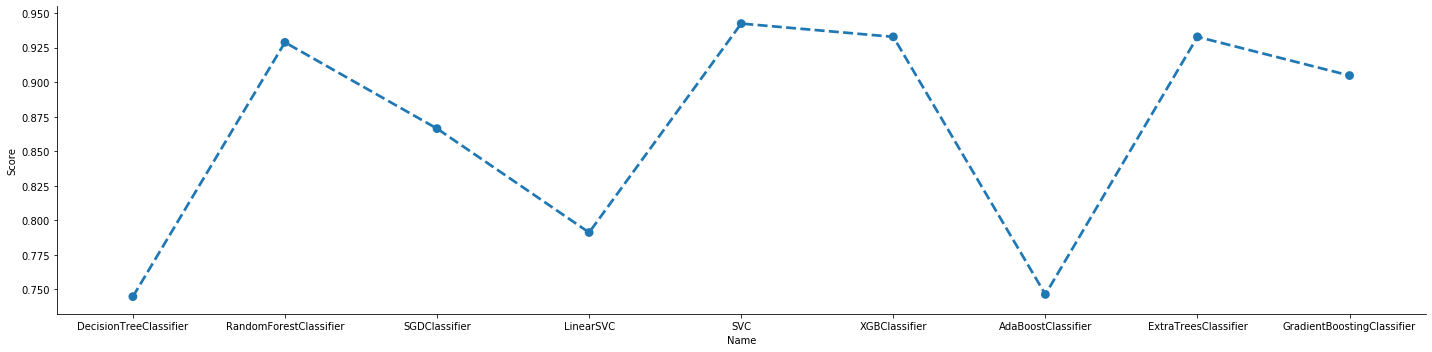

In [13]:
g = sns.catplot(x="Name", y="Score", kind='point', aspect=4, markers="o", linestyles= "--", data=models_compare)

# 5. Using Cross-Validation

Now, let's add Cross-Validation to the equation. It consists in splitting the training set in k-folds (10 in our case), and train the model in k-1 (9) folds while evaluating in the remaining fold. This results in an array with 10 evaluation scores. 

In [14]:
models = [tree.DecisionTreeClassifier(random_state=random_state), RandomForestClassifier(random_state=random_state), SGDClassifier(random_state=random_state), 
          LinearSVC(random_state=random_state, max_iter=10000), SVC(random_state=random_state, max_iter=10000),
            xgboost.XGBClassifier(random_state=random_state), AdaBoostClassifier(tree.DecisionTreeClassifier(random_state=random_state), random_state=random_state, learning_rate=0.1), 
          ExtraTreesClassifier(random_state=random_state), GradientBoostingClassifier(random_state=random_state)]
columns = ['Name', 'Score']
models_compare_cv = pd.DataFrame(columns=columns)
i=0
for model in models: 
    start_time = time.time()
    clf = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)
    models_compare_cv.loc[i, 'Name'] = model.__class__.__name__
    models_compare_cv.loc[i, 'Score'] = clf.mean()
    models_compare_cv.loc[i, 'Execution time'] = time.time()- start_time
    i+=1
models_compare_cv.sort_values(by='Score', ascending=False)

,Name,Score,Execution time
4,SVC,0.9456,20.880062
7,ExtraTreesClassifier,0.936267,5.970967
1,RandomForestClassifier,0.931467,5.214109
5,XGBClassifier,0.925867,396.002654
8,GradientBoostingClassifier,0.9072,331.797840
2,SGDClassifier,0.853333,6.939759
3,LinearSVC,0.790933,20.127550
6,AdaBoostClassifier,0.743733,1.764488
0,DecisionTreeClassifier,0.736,2.880408


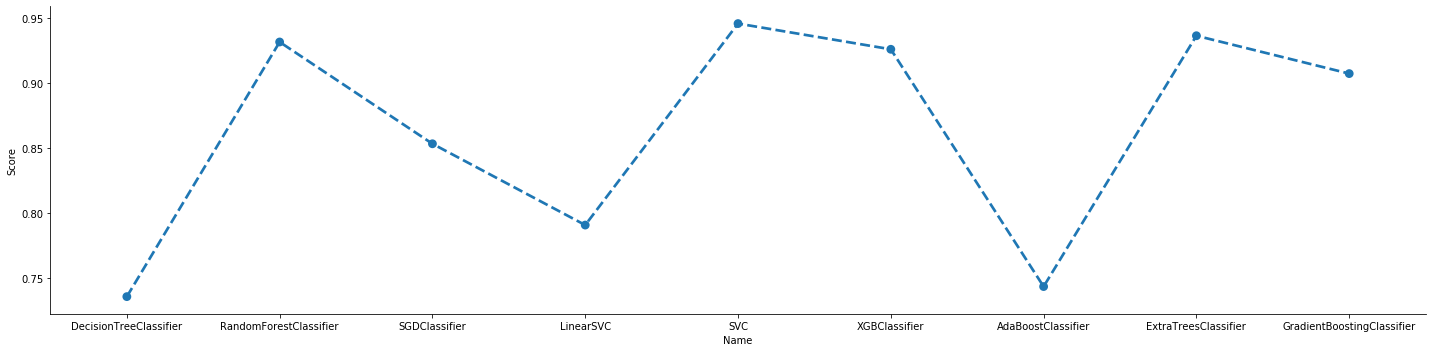

In [15]:
g = sns.catplot(x="Name", y="Score", kind='point', aspect=4, markers="o", linestyles= "--", data=models_compare_cv)

The next step would be tuning the hyperparameters, using either Grid Search or Random Search, to find the best model possible. Then, maybe try Ensemble Learning to stack a few good performance models to achieve even a higher accuracy. 

But my goal in this notebook was to introduce me in the NN world, so let's move into it.

# 6. Implementing a Neural Network

NNs are Machine Learning models inspired by the networks of biological neurons found in our brains. In this chapter, we will implement some different types of NNs, with different architectures, which will allows us to see how they perform with the same test dataset.

## Simple NN

As with the ML algorithms, we start by preprocessing our data. We define a net dataset, which later will be splitted in train and test, and a validation dataset, usefull during the training process:

In [16]:
X_net = train_reduced.drop('label', axis=1)
y_net = train_reduced['label']

In [17]:
X_val = train_val.drop('label', axis=1)
y_val = train_val['label']

The MNIST dataset is composed of N grayscale images of 28 x 28 pixels each, and when imported with Pandas, this results in an array of N instances with 784 (28 x 28) features/columns, each column indicating the pixel intensity. As we are going to train the NN using Gradient Descent, we must scale the features. So, by dividing each column by 255.0 we are scaling the pixel intensities down to the 0-1 range and conveting them to floats:

In [18]:
X_net = X_net.astype('float32')
X_net /= 255.0
X_val = X_val.astype('float32')
X_val /= 255.0

Finally, as the images are in grayscale (single color channel), we must reshape them in this way: (N, height, size, 1). If the images were in RGB, the last number of the reshape sould be 3.

In [19]:
X_net = X_net.values.reshape(-1,28,28,1)
X_val = X_val.values.reshape(-1,28,28,1)

Now, and as usual, we split the net dataset in train and test set, with a ratio of 0.75/0.25.

In [20]:
X_train_net, X_test_net, y_train_net, y_test_net = train_test_split(X_net, y_net, test_size=0.25, random_state=42)  

Next, we design the model. Now it's when things get complex. The NN is composed by an input layer, 3 dense hidden layers and an output layer. 

In [21]:
model_nn = keras.models.Sequential()
model_nn.add(keras.layers.Flatten(input_shape=[28,28,1]))
model_nn.add(keras.layers.Dropout(rate=0.2))
model_nn.add(keras.layers.Dense(300, activation='selu', kernel_initializer='lecun_normal'))
model_nn.add(keras.layers.Dropout(rate=0.2))
model_nn.add(keras.layers.Dense(300, activation='selu', kernel_initializer='lecun_normal'))
model_nn.add(keras.layers.Dropout(rate=0.2))
model_nn.add(keras.layers.Dense(300, activation='selu', kernel_initializer='lecun_normal'))
model_nn.add(keras.layers.Dropout(rate=0.2))
model_nn.add(keras.layers.Dense(10, activation='softmax'))

Let's see the model layer per layer:
- Flatten layer: the input layer whose role is to convert each input image into a 1D array. It does not have any parameters. Since it is the first layer in the model, we must specify the input_shape, which is the shape of the instances ((28, 28, 1) for the MNIST dataset).
- Dropout layers: is one of the most popular regularization techniques for deep neural networks. At every training step, every neuron (excluding the output neurons) has a probability p (dropout rate, 0.2 in our case) of being temporaly 'dropped out' or ignored, but it may be active during the next step. This implies that the remaining active neurons must pay attention to each of their input neurons, ending up being less sensitive to slight changes in the inputs, and hence we get a network that generalizes better.
- Dense layer with 300 neurons: each Dense layer manages its own weight matrix, containing all the connections weights between the neurons and their inputs.
    - number of neurons: the number of neurons in the input and output layers is determined by the task problem (for MNIST, 784 in the input and 10 for the output). For the hidden layers, it seems that using the same number of neurons in all hidden layers performs better that in the case of a pyramid (fewer and fewer neurons at each layer), plus there is only one hyperparameter to tune. As always, it depends on the dataset, so better check the two approaches by yourself.
    - activation: we choose SELU (Scaled ELU), which is a scaled variant of the ELU that allows the self-normalization of the network ( the output of each layer will tend to preserve a mean of 0 and standard deviation of 1 during training).
    - kernel_initializer: if we want to use SELU as an activation function, every hidden layer's weights must be initialized with LeCun normal initialization.
- Dense layer with 10 neurons: the output layer, with 10 neurons (one per class) and an softmax activation because the classes are exclusive.

We can display all the layers, with their output shapes and their parameters:

In [22]:
model_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dropout (Dropout)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               9

As for the learning rate, we chose to use the 1cycle scheduling, which consists in setting an initial learning rate, increasing it linearly during the first half of the training, the decreasing it to initial value during the second half of the training process, linearly again.

In [23]:
K = keras.backend
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

Now, we are ready to compile and fit the model. We set the batch_size and the number of epochs and prepare the 1cycle scheduling for the learning rate. 
When compiling the model, we chose:
- loss: 'sparse_categorical_crossentropy', as we have not converted the labels (y) to categorical.
- optimizer: SGD, with an initial learning rate and a momentum optimization to boost the training.
- metrics: 'accuracy'
Finally, we fit the compiled model to the training data, using the validation data to have a first sight of the generalization of the model, and setting one callback, the 1cycle scheduling for the learning rate.

We store the training process in history to see the evolution of the training with the epochs.

In [24]:
batch_size = 128
n_epochs = 25
onecycle = OneCycleScheduler(len(X_train_net) // batch_size * n_epochs, max_rate=0.05)
model_nn.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=0.1, momentum=0.9), metrics=['accuracy'])
history = model_nn.fit(X_train_net, y_train_net, epochs=n_epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[onecycle])

Train on 3750 samples, validate on 5000 samples
Epoch 1/25
3750/3750 [==============================] - 1s 329us/sample - loss: 1.3036 - accuracy: 0.5560 - val_loss: 0.5060 - val_accuracy: 0.8494
Epoch 2/25
3750/3750 [==============================] - 0s 55us/sample - loss: 0.5509 - accuracy: 0.8240 - val_loss: 0.4140 - val_accuracy: 0.8794
Epoch 3/25
3750/3750 [==============================] - 0s 52us/sample - loss: 0.4643 - accuracy: 0.8523 - val_loss: 0.3901 - val_accuracy: 0.8896
Epoch 4/25
3750/3750 [==============================] - 0s 53us/sample - loss: 0.4386 - accuracy: 0.8587 - val_loss: 0.3870 - val_accuracy: 0.8878
Epoch 5/25
3750/3750 [==============================] - 0s 55us/sample - loss: 0.4286 - accuracy: 0.8653 - val_loss: 0.3810 - val_accuracy: 0.9006
Epoch 6/25
3750/3750 [==============================] - 0s 63us/sample - loss: 0.4027 - accuracy: 0.8736 - val_loss: 0.4355 - val_accuracy: 0.8816
Epoch 7/25
3750/3750 [==============================] - 0s 57us/sampl

Let's see the accuracy of the training and validation data per epoch:

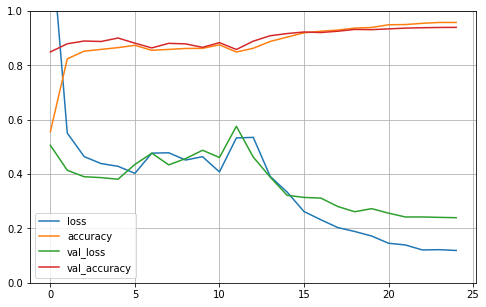

In [25]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

Finally, we evaluate the model with the test data:

In [26]:
model_nn.evaluate(X_test_net, y_test_net)

1250/1250 [==============================] - 0s 65us/sample - loss: 0.2883 - accuracy: 0.9360


[0.28828834884166715, 0.936]

## Random Search in the simple NN

As in ML algorithms, tune the hyperparameters of a NN may improve its accuracy. But as NN are so flexible, the number of hyperparameters to tune could be also large.

We begin by defining a function that will compile a model given a set of hyperparameters, but in this case with the number of hidden layers variable (in the for loop):

In [27]:
def build_model(n_hidden=1, n_neurons =30, learning_rate=3e-3, dropout_rate=0.2):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=[28,28,1]))
    for layer in range(n_hidden):
        model.add(keras.layers.Dropout(rate=dropout_rate))
        model.add(keras.layers.Dense(n_neurons, activation='selu', kernel_initializer='lecun_normal'))
    model.add(keras.layers.Dense(10, activation='softmax'))
    optimizer=keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

Next, we create a KerasClassifier based on the build_model. This allows to use the model as a normal Scikit-Learn classifier:

In [28]:
keras_class = keras.wrappers.scikit_learn.KerasClassifier(build_model)

And now we define the hyperparameters to tune and their possible values, in a grid:
- 'n_hidden': the number of hidden layers.
- 'n_neurons': the number of neurons per hidden layer.
- 'learning_rate': different learning rates to try.
- 'dropout_rate': for the Dropout layers.

In [29]:
param_distribs = {
    'n_hidden' : [3, 4, 5],
    'n_neurons' : [200, 250, 300],
    'learning_rate' : [0.01, 0.1, 1],
    'dropout_rate' : [0.2, 0.3, 0.4],
}

Instead of using GridSearch, we use randomized seach due the large number of hyperparameters.

In [30]:
from sklearn.model_selection import RandomizedSearchCV
batch_size = 128
n_epochs = 25
onecycle = OneCycleScheduler(len(X_train_net) // batch_size * n_epochs, max_rate=0.05)
start_time = time.time()
rnd_search_cv = RandomizedSearchCV(keras_class, param_distribs, n_iter=30, cv=3)
rnd_search_cv.fit(X_train_net, y_train_net, verbose=0, epochs=30, validation_data=(X_val, y_val), callbacks=[onecycle])


1250/1250 [==============================] - 0s 89us/sample - loss: 1.2069 - accuracy: 0.6480


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x00000180DA7A77C8>,
                   iid='deprecated', n_iter=30, n_jobs=None,
                   param_distributions={'dropout_rate': [0.2, 0.3, 0.4],
                                        'learning_rate': [0.01, 0.1, 1],
                                        'n_hidden': [3, 4, 5],
                                        'n_neurons': [200, 250, 300]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [31]:
print('Execution time:',time.time()- start_time)

Execution time: 1828.4956324100494


Once finished, we can acces the best parameters found and the best score:

In [32]:
rnd_search_cv.best_params_, rnd_search_cv.best_score_

({'n_neurons': 300, 'n_hidden': 5, 'learning_rate': 0.01, 'dropout_rate': 0.2},
 0.6362666686375936)

And evaluate the best trained Keras model with the test data:

In [33]:
model = rnd_search_cv.best_estimator_.model
model.evaluate(X_test_net, y_test_net)

1250/1250 [==============================] - 0s 78us/sample - loss: 1.0280 - accuracy: 0.7248


[1.0279814422607423, 0.7248]

## Hyperopt

Hyperopt (https://hyperopt.github.io/hyperopt/) is a popular library for optimizing hyperparameters. It works in a similar way than RandomSearch, so let's give it a try.

First, we define our hyperparameter space:
- 'num_layers': a default value (two layers) and other options, each one with a uniformly generated number of neurons.
- 'units1' and 'units2': the number of neurons in hidden layers one and two, respectively. It will generate a value between the given constraints.
- 'batch_size': a value generated inside the given interval.
- 'learning_rate': it will pick up one of the available values.

In [34]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
space = {'choice' : hp.choice('num_layers', [{'layers':'two', },
                    {'layers':'three',
                    'units3': hp.uniform('units3', 64,1024),}
                    ]),
            'units1': hp.uniform('units1', 64,1024),
            'units2': hp.uniform('units2', 64,1024),
            'batch_size' : hp.uniform('batch_size', 28,128),
            'learning_rate' : hp.choice('learning_rate', [0.0001, 0.001, 0.01, 0.1, 1])
        }

Next, we define, compile and fit the model, using the space defined:

In [35]:
def model (params):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=[28,28,1]))
    model.add(keras.layers.Dense(params['units1'], activation='selu', kernel_initializer='lecun_normal'))
    model.add(keras.layers.Dense(params['units2'], activation='selu', kernel_initializer='lecun_normal'))
    if params['choice']['layers'] == 'three':
        model.add(keras.layers.Dense(params['choice']['units3'], activation='selu', kernel_initializer='lecun_normal'))
    model.add(keras.layers.Dense(10, activation='softmax'))
    optimizer=keras.optimizers.SGD(learning_rate=params['learning_rate'], momentum=0.9)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.fit(X_train_net, y_train_net, verbose=0, batch_size=32,epochs=30, validation_data=(X_val, y_val), callbacks=[onecycle])
    test_score, test_acc = model.evaluate(X_test_net, y_test_net, verbose = 0)
    return{'loss': test_acc, 'score': test_score, 'status': STATUS_OK}

We search for the best hyperparameters set, using the 'max_evals' value to control how many different models we want to train:

In [36]:
best = fmin(model, space , algo=tpe.suggest, max_evals=50, trials=Trials())

100%|██████████| 50/50 [17:47<00:00, 21.35s/trial, best loss: 0.053599998354911804]


And this the best set of hyperparameters that Hyperopt found:

In [37]:
best

{'batch_size': 74.75270204960196,
 'learning_rate': 4,
 'num_layers': 1,
 'units1': 553.3321436855581,
 'units2': 594.8564985732473,
 'units3': 349.41557525239205}

## CNN

Convolutional Neural Networks (CNNs) can achieve an awesome performance in complex tasks as image recognition. Let's see how they perform against a 'normal' Neural Network.

First we design the network. Let's go layer per layer:
- the first layer uses 64 7x7 filters and sets the input_shape=[28, 28, 1].
- next we add a max pooling layer with a pool size of 2, so it divides each spatial dimension by 2.
- we repeat the strucuture: two Convolutional layers followed by a max pooling layer. The number of filters in the conv layers grows (from 64 to 256).
- last, the fully connected network, which first flatten the inputs and reduce the overfitting using Dropout layers.


Once we have our CNN, we compile and fit it with the training data:

In [47]:
batch_size = 32
n_epochs = 50
model_cnn = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation='relu', padding='same', input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128,3,activation='relu', padding='same'),
    keras.layers.Conv2D(128,3,activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256,3,activation='relu', padding='same'),
    keras.layers.Conv2D(256,3,activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
    ])
model_cnn.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.SGD(lr=0.001, momentum=0.9), metrics=['accuracy'])
history = model_cnn.fit(X_train_net, y_train_net, epochs=n_epochs, batch_size=batch_size, validation_data=(X_val, y_val))

Train on 3750 samples, validate on 5000 samples
Epoch 1/50
3750/3750 [==============================] - 4s 976us/sample - loss: 2.2986 - accuracy: 0.1203 - val_loss: 2.2916 - val_accuracy: 0.1244
Epoch 2/50
3750/3750 [==============================] - 3s 711us/sample - loss: 2.2842 - accuracy: 0.1749 - val_loss: 2.2659 - val_accuracy: 0.2964
Epoch 3/50
3750/3750 [==============================] - 3s 786us/sample - loss: 2.2456 - accuracy: 0.2331 - val_loss: 2.1836 - val_accuracy: 0.3898
Epoch 4/50
3750/3750 [==============================] - 3s 706us/sample - loss: 2.1228 - accuracy: 0.2853 - val_loss: 1.8671 - val_accuracy: 0.5360
Epoch 5/50
3750/3750 [==============================] - 3s 716us/sample - loss: 1.7516 - accuracy: 0.4133 - val_loss: 1.1983 - val_accuracy: 0.7022
Epoch 6/50
3750/3750 [==============================] - 3s 698us/sample - loss: 1.3682 - accuracy: 0.5363 - val_loss: 0.7647 - val_accuracy: 0.8250
Epoch 7/50
3750/3750 [==============================] - 3s 687us

We can plot again the evolution of accuracies an losses with the epochs of training:

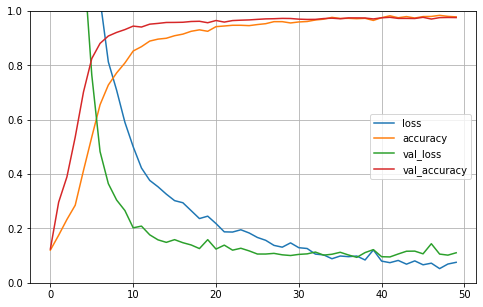

In [48]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

And finally, evaluate the CNN with the test set:

In [49]:
model_cnn.evaluate(X_test_net, y_test_net)

1250/1250 [==============================] - 0s 199us/sample - loss: 0.1173 - accuracy: 0.9736


[0.11731061248090119, 0.9736]

## ResNet-34 CNN

As a last step, let's build from scratch a Residual Network, used to won the ILSVRC 2015 challenge. Thanks again to the Keras API and its expressiveness.

In [41]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides = strides, padding='same', use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters,3 , strides=1, padding='same', use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides, padding='same', use_bias=False),
                keras.layers.BatchNormalization()]
def call(self, inputs):
    Z = inputs 
    for layer in self.main_layers:
        Z= layer(Z)
    skip_Z = inputs
    for layer in self.skip_layers:
        skip_Z= LAYER(skip_Z)
    return self.activation(Z + skip_Z)


In [42]:
model_res = keras.models.Sequential()
model_res.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[28, 28, 1], padding='same', use_bias=False))
model_res.add(keras.layers.BatchNormalization())
model_res.add(keras.layers.Activation('relu'))
model_res.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model_res.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model_res.add(keras.layers.GlobalAvgPool2D())
model_res.add(keras.layers.Flatten())
model_res.add(keras.layers.Dense(10, activation='softmax'))

In [43]:
model_res.summary()

Model: "sequential_143"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 14, 14, 64)        3136      
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 7, 7, 64)          0         
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 7, 7, 64)          0         
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 7, 7, 64)       

In [44]:
n_epochs = 50
batch_size = 32
model_res.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.SGD(lr=0.001, momentum=0.9), metrics=['accuracy'])
model_res.fit(X_train_net, y_train_net, epochs=n_epochs, batch_size=batch_size, validation_data=(X_val, y_val))

Train on 3750 samples, validate on 5000 samples
Epoch 1/50
3750/3750 [==============================] - 2s 420us/sample - loss: 2.1837 - accuracy: 0.2811 - val_loss: 2.2484 - val_accuracy: 0.2806
Epoch 2/50
3750/3750 [==============================] - 1s 270us/sample - loss: 1.8906 - accuracy: 0.4563 - val_loss: 2.1680 - val_accuracy: 0.2940
Epoch 3/50
3750/3750 [==============================] - 1s 285us/sample - loss: 1.7954 - accuracy: 0.5077 - val_loss: 2.0317 - val_accuracy: 0.3520
Epoch 4/50
3750/3750 [==============================] - 1s 308us/sample - loss: 1.7225 - accuracy: 0.5256 - val_loss: 1.8484 - val_accuracy: 0.4214
Epoch 5/50
3750/3750 [==============================] - 1s 284us/sample - loss: 1.6615 - accuracy: 0.5549 - val_loss: 1.6901 - val_accuracy: 0.5194
Epoch 6/50
3750/3750 [==============================] - 1s 276us/sample - loss: 1.6137 - accuracy: 0.5741 - val_loss: 1.5874 - val_accuracy: 0.5424
Epoch 7/50
3750/3750 [==============================] - 1s 267us

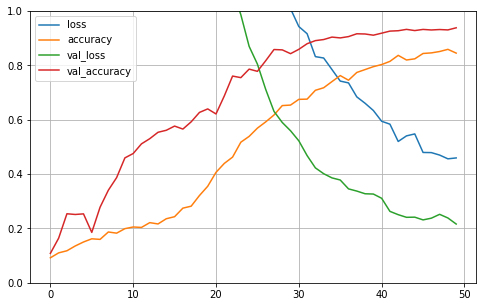

In [45]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [46]:
model_res.evaluate(X_test_net, y_test_net)

1250/1250 [==============================] - 0s 150us/sample - loss: 0.9222 - accuracy: 0.7448


[0.922222617149353, 0.7448]

# 7. Submitting the solution

CNN achieve the highest accuracy, hence wi will use it with the test data to submit our solution:

In [51]:
X_submit = test.astype('float32')
X_submit /= 255.0
X_submit = X_submit.values.reshape(-1,28,28,1)

In [52]:
y_pred = model_cnn.predict(X_submit)

In [56]:
y_pred_final = np.argmax(y_pred, axis=1)
y_pred_final

array([2, 0, 9, ..., 3, 9, 2], dtype=int64)

In [59]:
submission = pd.DataFrame()
submission['ImageId'] = pd.Series(range(1,28001))
submission['Label'] = y_pred_final
submission.head()
submission.to_csv('submit.csv', index=False)

And that's all. Hope you like it.